# BBC News Classification with BERT: Lab
# Solution

## Overview
As a junior data scientist at NewsInsight, a media analytics company, you've been tasked with building an automated news categorization system. Your team needs to classify incoming news articles into appropriate categories to help journalists, researchers, and business analysts quickly find relevant information.

The company receives thousands of articles daily from various sources. Currently, human editors spend significant time manually categorizing these articles, which is time-consuming and inconsistent. Your manager has asked you to develop a machine learning solution that can automatically categorize news articles into predefined categories (business, entertainment, politics, sport, tech).

This project will follow the BERT fine-tuning process you've learned:
1. Understanding data and defining requirements
2. Selecting and preparing the BERT model
3. Data preparation and tokenization
4. Model architecture design
5. Fine-tuning the model
6. Evaluation and refinement

Successfully implementing this system will significantly improve workflow efficiency, allowing editors to focus on content quality rather than manual categorization.

## Part 1: Environment Setup and Data Loading

In [10]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import seaborn as sns

# Set random seeds for reproducibility
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

set_seed()

In [11]:
# Load the data from csv file
df = pd.read_csv("bbc_news_data.csv",
                 sep="\t",
                 quoting=3,  # 3 = csv.QUOTE_NONE
                 on_bad_lines='skip',  # or on_bad_lines='skip' for newer pandas
                 engine='python')  # use python engine for flexibility
df.head()


,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [12]:
df['category'].unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

## Part 2: Data Exploration and Preprocessing

Explore the dataset, displaying basic information and:
- Analyze category distribution
- Check text length distribution
- Train test split data, use 75-25 split

   category filename                              title  \
0  business  001.txt  Ad sales boost Time Warner profit   
1  business  002.txt   Dollar gains on Greenspan speech   
2  business  003.txt  Yukos unit buyer faces loan claim   
3  business  004.txt  High fuel prices hit BA's profits   
4  business  005.txt  Pernod takeover talk lifts Domecq   
5  business  006.txt   Japan narrowly escapes recession   
6  business  007.txt   Jobs growth still slow in the US   
7  business  008.txt   India calls for fair trade rules   
8  business  009.txt  Ethiopia's crop production up 24%   
9  business  010.txt  Court rejects $280bn tobacco case   

                                             content  
0   Quarterly profits at US media giant TimeWarne...  
1   The dollar has hit its highest level against ...  
2   The owners of embattled Russian oil giant Yuk...  
3   British Airways has blamed high fuel prices f...  
4   Shares in UK drinks and food firm Allied Dome...  
5   Japan's economy 

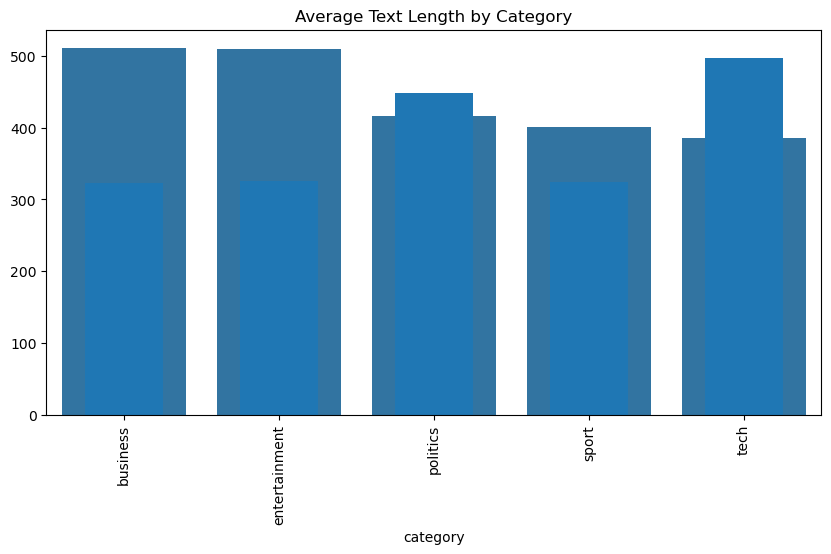

In [13]:
# Explore the first 10 rows
print(df.head(10))

# Basic info and describe
print(df.info())
print(df.describe())

# Category distribution
category_counts = df['category'].value_counts()
category_counts

# Visualize category distribution
sns.barplot(x=category_counts.index, y=category_counts.values)

# Text length analysis
df['text_length'] = df['content'].apply(lambda x: len(str(x).split()))
print(f"Average text length: {df['text_length'].mean()}")
print(f"Min text length: {df['text_length'].min()}")
print(f"Max text length: {df['text_length'].max()}")

# Visualize text length by category
df.groupby('category')['text_length'].mean().plot(kind='bar', figsize=(10, 5))
plt.title('Average Text Length by Category')

# Check for missing values
print(df.isnull().sum())

# Map category labels to integers for classification
categories = list(df['category'].unique())
category_mapping = {category: i for i, category in enumerate(categories)}
df['label'] = df['category'].map(category_mapping)

# Rename content column into text for hugging face
df.rename(columns={'content': 'text'}, inplace=True)

# Split into train, validation, and test sets, make sure to stratify based on category, keep features and target together for now
# First, create train+validation and test sets
train_val_df, test_df,  = train_test_split(df, test_size=0.25, random_state=42, stratify=df['category'])
# Then split train+validation into separate train and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42, stratify=train_val_df['category'])

# Extract labels as numpy arrays
train_labels = train_df['label'].values
val_labels = val_df['label'].values
test_labels = test_df['label'].values

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Ensure categories are distributed properly across splits
print("\nCategory distribution in training set:")
print(train_df['category'].value_counts())
print("\nCategory distribution in validation set:")
print(val_df['category'].value_counts())
print("\nCategory distribution in test set:")
print(test_df['category'].value_counts())

## Part 3: Choose Your Model Approach
You can implement either the TensorFlow approach OR the Hugging Face approach. Delete the one you do not use.

### ------ TensorFlow Approach --------
Implement BERT with TensorFlow and TensorFlow Hub
- Import required libraries
- Select and load a BERT model
- Create datasets
 - Build model architecture
 - Fine-tune the model
 - Evaluate performance
 - Create visuals for train and validation data metrics across epochs

In [14]:
# Make sure to set legacy Keras to work with TF Hub BERT before you import
os.environ['TF_USE_LEGACY_KERAS']= '1'

# Import TensorFlow-specific libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

# Select and load BERT model, smaller BERT model for faster training
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

# load preprocessing model and BERT model from tensorflow hub
map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

# Create TensorFlow datasets
def create_tf_dataset(texts, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((texts, labels))
    # shuffle so that model does not overfit
    if shuffle:
        dataset = dataset.shuffle(len(texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Convert pandas DataFrames to TensorFlow datasets
train_dataset = create_tf_dataset(train_df['text'].values, train_labels)
val_dataset = create_tf_dataset(val_df['text'].values, val_labels)
# Make sure to not shuffle for test data
test_dataset = create_tf_dataset(test_df['text'].values, test_labels, shuffle=False)

# Build the BERT model
def build_tf_classifier_model():
    # Text input
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # Preprocessing layer
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)

    # BERT encoder - set trainable=True for fine-tuning
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
    outputs = encoder(encoder_inputs)

    # Use the pooled output for classification
    net = outputs['pooled_output']

    # Add dropout for regularization
    net = tf.keras.layers.Dropout(0.2)(net)

    # Add classification layer (for 5 categories)
    net = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(net)

    # Create model
    model = tf.keras.Model(text_input, net)
    return model

# Create model
tf_classifier_model = build_tf_classifier_model()
tf_classifier_model.summary()

# Compile the model
# Using sparse categorical crossentropy since our labels are integers
loss = tf.keras.losses.SparseCategoricalCrossentropy()
# Select accuracy as metric
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

# Set up learning rate and optimizer
init_lr = .0005
optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr)

# Compile the model
tf_classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Set up early stopping callback based on validation accuracy
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True)


# Train the model for 5 epochs (not enough epochs most likely but to save on time)
print('Fine-tuning BERT model...')
history = tf_classifier_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[early_stopping])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

40/40 [==============================] - 6s 99ms/step - loss: 1.6623 - sparse_categorical_accuracy: 0.2534 - val_loss: 1.3909 - val_sparse_categorical_accuracy: 0.4652
Epoch 2/5
39/40 [============================>.] - ETA: 0s - loss: 1.2844 - sparse_categorical_accuracy: 0.5016WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


40/40 [==============================] - 4s 94ms/step - loss: 1.2840 - sparse_categorical_accuracy: 0.5012 - val_loss: 1.0856 - val_sparse_categorical_accuracy: 0.7290
Epoch 3/5
39/40 [============================>.] - ETA: 0s - loss: 1.0037 - sparse_categorical_accuracy: 0.6827WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


40/40 [==============================] - 4s 99ms/step - loss: 1.0029 - sparse_categorical_accuracy: 0.6827 - val_loss: 0.8753 - val_sparse_categorical_accuracy: 0.8177
Epoch 4/5
39/40 [============================>.] - ETA: 0s - loss: 0.8341 - sparse_categorical_accuracy: 0.7620WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


40/40 [==============================] - 4s 100ms/step - loss: 0.8335 - sparse_categorical_accuracy: 0.7626 - val_loss: 0.7362 - val_sparse_categorical_accuracy: 0.8369
Epoch 5/5
39/40 [============================>.] - ETA: 0s - loss: 0.7093 - sparse_categorical_accuracy: 0.8141WARNING:tensorflow:Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy


40/40 [==============================] - 4s 97ms/step - loss: 0.7093 - sparse_categorical_accuracy: 0.8137 - val_loss: 0.6336 - val_sparse_categorical_accuracy: 0.8681


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate model on testing data
test_loss, test_accuracy = tf_classifier_model.evaluate(test_dataset)
print(f'Test accuracy (TensorFlow): {test_accuracy:.3f}')

# Step 2: Get predictions
y_pred_probs = tf_classifier_model.predict(test_dataset)
y_pred = tf.argmax(y_pred_probs, axis=1).numpy()

# Step 3: Get true labels
y_true = [label.numpy() for _, label in test_dataset.unbatch()]

# Step 4: Calculate precision
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Test precision (TensorFlow): {test_precision:.3f}')
print(f'Test recall (TensorFlow): {test_recall:.3f}')
print(f'Test F1 score (TensorFlow): {test_f1:.3f}')

18/18 [==============================] - 1s 69ms/step - loss: 0.6260 - sparse_categorical_accuracy: 0.8725
Test accuracy (TensorFlow): 0.873
18/18 [==============================] - 1s 70ms/step
Test precision (TensorFlow): 0.880
Test recall (TensorFlow): 0.873
Test F1 score (TensorFlow): 0.873


In [16]:
def predict_article_category(text, model=tf_classifier_model):
    prediction = model.predict([text])[0]
    predicted_class_id = np.argmax(prediction)
    predicted_category = categories[predicted_class_id]
    confidence = float(prediction[predicted_class_id])
    return predicted_category, confidence

sample_text = """President Donald Trump announced Thursday that the United States and China have formally signed a trade agreement, bringing an end to months of negotiations. The deal cements the informal understanding reached earlier during talks in Geneva, marking a significant step in stabilizing trade relations between the two countries. We just signed with China yesterday, Trump said during a briefing at the White House, though he did not provide further details. The White House Council of Economic Advisers chairman Stephen Miran told Yahoo Finance on Thursday that he expects the Trump administration to extend the tariff pause for countries negotiating in good faith. I mean, you don't blow up a deal that's that's in process and making really good faith, sincere, authentic progress by dropping a tariff bomb in it, Miran told Yahoo Finance's Brian Sozzi. In recent weeks, President Trump and administration officials have signaled a willingness to roll back the self-imposed tariff deadline of July 9 as pressure builds for talks to turn into pacts. From Canada to Japan, key trade deals are struggling to get over the finish line with just two weeks to go. Trump and officials have warned that he could soon simply tell countries their tariff rates, raising questions about the status of negotiations. Miran said that he doesn't see the aggregate tariff rate falling materially below the 10% level in the long run, but some countries may negotiate more favorable duties while others will see a return of the steeper "Liberation Day" tariffs.So far, Trump has firmed up a trade deal with the United Kingdom. In Canada, Prime Minister Mark Carney's government threatened to hike tariffs by late July on US imports of steel and aluminum, after Trump ballooned US levies on those metals. The countries are aiming for a deal by mid-July. The European Union has also vowed to retaliate if the US sticks with its baseline 10% tariffs, according to a report in Bloomberg. Trump has threatened tariffs of up to 50% on EU imports."""
sample_text2 = """Fleming, a forward from Saint Joseph's, averaged 14.7 points, 8.5 rebounds and 1.5 blocks last season, ranking in the top four in the Atlantic 10 in rebounds and blocks.

Among the familiar names going early in the second round were Broome; Creighton center Ryan Kalkbrenner, the four-time Big East Defensive Player of Year, who was selected one pick earlier by the Charlotte Hornets at No. 34; and Marquette All-American Kam Jones, whose rights were acquired by the Eastern Conference champion Indiana Pacers after he was taken 38th by the San Antonio Spurs.

Charlotte also took Sion James at No. 33, and the Cleveland Cavaliers picked Tyrese Proctor at 49, giving Duke all five of its starters being taken after Cooper Flagg, Kon Knueppel and Khaman Maluach went in the top 10.

The Dallas Mavericks, who selected Flagg with the No. 1 pick Wednesday, did not have a selection when Round 2 began. They had the option to try to trade in, and a number of other teams moved around as the draft went on.

The Orlando Magic were one of them, acquiring the draft rights to French forward Noah Penda at No. 32 from the Boston Celtics in exchange for Nos. 46 and 57, a second-round pick in 2026 and another in 2027. Orlando still owns four first-round picks and nine second-rounders over the next seven years.

The 6-foot-8, 225-pound Penda offers inside-out versatility and defensive potential. The 20-year-old averaged 10.3 points, 5.5 rebounds and 2.6 assists in 33 games last year in France's top league.

The Los Angeles Lakers also moved up, agreeing to acquire the rights to Adou Thiero, the 36th pick from Arkansas, from the Timberwolves in exchange for the No. 45 pick and cash. Because the Lakers sent out cash in the deal, they will be required to stay below the second apron next season.

The league began using the two-night format last year, believing the event was ending too late when all 60 picks, along with approving trades, were being done in one night.

Teams like the new system, with the ability to catch their breath and evaluate after the first round, but the players' side doesn't enjoy the potentially lengthy wait for those who are on the fringe of the first round but then have to wait another night if they tumble into the second.

The draft had 59 picks this time, with the New York Knicks having been penalized their second-round selection for tampering by negotiating with Jalen Brunson too soon before eventually signing the guard away from Dallas in 2022.

The NBA points to the success of players such as Brunson, who became an All-NBA selection in New York, and three-time MVP Nikola Jokic of the Denver Nuggets when touting the types of difference-makers who could come out of the second round.

Broome might become one of those players. The runner-up to Flagg for The Associated Press men's college basketball national player of the year award was banged-up late in the season after leading the Tigers to the Final Four, and that might have led to some poor testing at the NBA combine.

But Broome has believed he was an NBA player ever since his Morehead State team played against powerhouse Kentucky earlier in his career and he held his own. He believes he can do the same when he gets to camp with Joel Embiid and the 76ers."""
sample_text3 = """The US district judge Vince Chhabria, in San Francisco, said in his decision on the Meta case that the authors had not presented enough evidence that the technology company’s AI would cause “market dilution” by flooding the market with work similar to theirs. As a consequence Meta’s use of their work was judged a “fair use” – a legal doctrine that allows use of copyright protected work without permission – and no copyright liability applied.

However, the ruling offered hope for American creative professionals who argue that training AI models on their work without permission is illegal.

Chhabria said using copyrighted work without permission to train large language models – the core technology behind chatbots like ChatGPT – would be unlawful in “many circumstances”, splitting with another federal judge in San Francisco who found on Monday in a separate lawsuit that Anthropic’s AI training made “fair use” of copyrighted materials.

Chhabria also indicated the creative industries could launch further suits.

“This ruling does not stand for the proposition that Meta’s use of copyrighted materials to train its language models is lawful,” he wrote.

Chhabria dismissed as “nonsense” Meta’s claim that the public interest would be “badly disserved” if AI developers were blocked from using copyright-protected works freely.

In his conclusion, Chhabria expressed sympathy for the argument that LLMs take authors’ work and then turn it against them.

He wrote: “No matter how transformative LLM training may be, it’s hard to imagine that it can be fair use to use copyrighted books to develop a tool to make billions or trillions of dollars while enabling the creation of a potentially endless stream of competing works that could significantly harm the market for those books.”

The doctrine of fair use allows the use of copyrighted works without the copyright owner’s permission in some circumstances and is a key defence for the tech companies.

"""
print(predict_article_category(sample_text))
print(predict_article_category(sample_text2))
print(predict_article_category(sample_text3))



1/1 [==============================] - 0s 237ms/step
('business', 0.33463260531425476)
1/1 [==============================] - 0s 25ms/step
('sport', 0.6393533945083618)
1/1 [==============================] - 0s 25ms/step
('politics', 0.34128764271736145)


## Part 4: Model Analysis and Inference
Analyze model performance on testing data
- Create confusion matrix visualization
- Analyze misclassifications
- Identify strengths and weaknesses

### Tensorflow Model

18/18 [==============================] - 1s 71ms/step


<Figure size 1000x800 with 0 Axes>

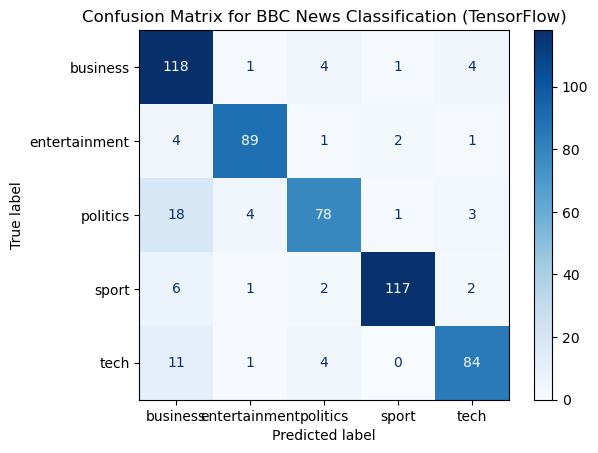


Classification Report:
               precision    recall  f1-score   support

     business       0.75      0.92      0.83       128
entertainment       0.93      0.92      0.92        97
     politics       0.88      0.75      0.81       104
        sport       0.97      0.91      0.94       128
         tech       0.89      0.84      0.87       100

     accuracy                           0.87       557
    macro avg       0.88      0.87      0.87       557
 weighted avg       0.88      0.87      0.87       557


Model Strengths and Weaknesses:

Strengths:
- Overall accuracy: 0.8725
- Best performing category: sport

Weaknesses:
- Worst performing category: politics


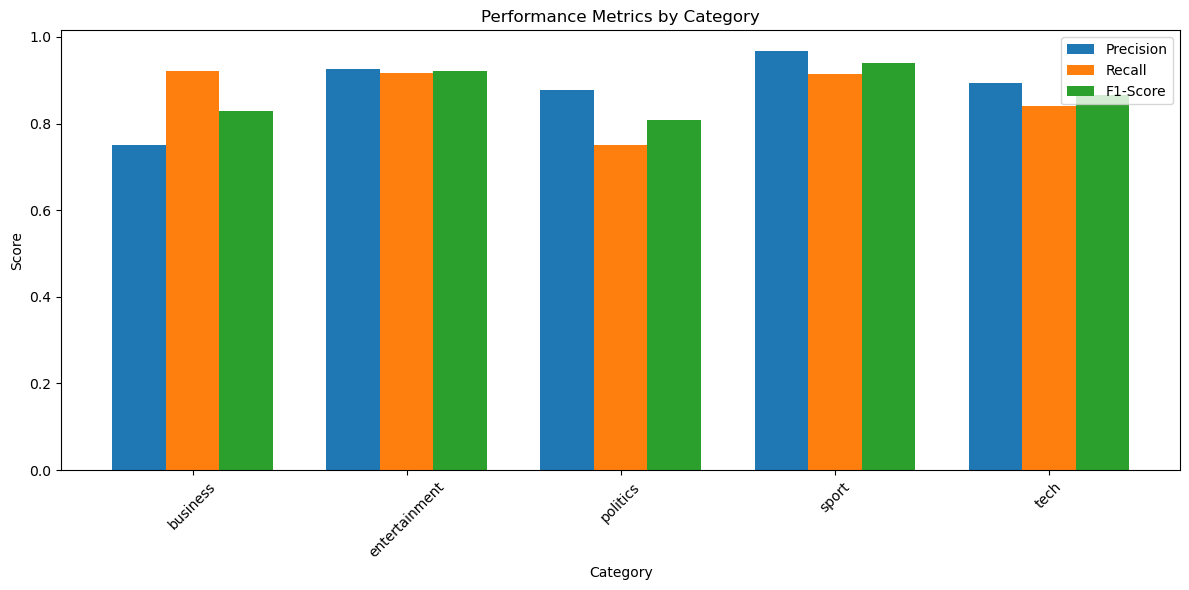

In [17]:
# Generate predictions for the test set
test_predictions = tf_classifier_model.predict(test_dataset)
y_pred = tf.argmax(test_predictions, axis=1).numpy()

# Get true labels from testing data
y_true = [labels.numpy() for _, labels in test_dataset.unbatch()]

# Create and visualize the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for BBC News Classification (TensorFlow)')
plt.grid(False)
plt.show()

# Create classification report
report = classification_report(y_true, y_pred, target_names=categories, output_dict=True)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=categories))

# Identify strengths and weaknesses
print("\nModel Strengths and Weaknesses:")

# Calculate per-class metrics (use classification report)
per_class_metrics = {category: {
    'precision': report[category]['precision'],
    'recall': report[category]['recall'],
    'f1-score': report[category]['f1-score'],
    'support': report[category]['support']
} for category in categories}

# Find best and worst performing categories
f1_scores = {cat: metrics['f1-score'] for cat, metrics in per_class_metrics.items()}
best_category = max(f1_scores.items(), key=lambda x: x[1])
worst_category = min(f1_scores.items(), key=lambda x: x[1])

print(f"\nStrengths:")
print(f"- Overall accuracy: {report['accuracy']:.4f}")
print(f"- Best performing category: {best_category[0]}")
print(f"\nWeaknesses:")
print(f"- Worst performing category: {worst_category[0]}")

# Visualize per-class performance
plt.figure(figsize=(12, 6))
categories_indices = range(len(categories))
width = 0.25

plt.bar([i - width for i in categories_indices],
        [per_class_metrics[cat]['precision'] for cat in categories],
        width=width, label='Precision')
plt.bar(categories_indices,
        [per_class_metrics[cat]['recall'] for cat in categories],
        width=width, label='Recall')
plt.bar([i + width for i in categories_indices],
        [per_class_metrics[cat]['f1-score'] for cat in categories],
        width=width, label='F1-Score')

plt.xlabel('Category')
plt.ylabel('Score')
plt.title('Performance Metrics by Category')
plt.xticks(categories_indices, categories, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# Create a function for model inference on new articles
def predict_article_category(text, model=tf_classifier_model):
    """
    Predict the category of a news article using the fine-tuned model.

    Args:
        text (str): The text of the news article
        model: The fine-tuned TensorFlow model

    Returns:
        dict: Prediction results including category and confidence scores
    """
    # Make prediction
    prediction = model.predict([text])[0]

    # Get the predicted category and confidence
    predicted_class_id = np.argmax(prediction)
    predicted_category = categories[predicted_class_id]
    confidence = float(prediction[predicted_class_id])

    # Get confidence for all categories
    category_confidences = {categories[i]: float(prediction[i]) for i in range(len(categories))}

    # Sort categories by confidence (descending)
    sorted_categories = sorted(category_confidences.items(), key=lambda x: x[1], reverse=True)

    return {
        'text': text[:100] + '...' if len(text) > 100 else text,
        'predicted_category': predicted_category,
        'confidence': confidence,
        'all_confidences': sorted_categories
    }

# Test the inference function with example articles
sample_articles = [
    "The tech giant announced the release of their new smartphone that features advanced AI capabilities and improved battery life. The product will be available in stores next month.",
    "The football team secured their victory in the final minutes with a spectacular goal. The win puts them at the top of the league table.",
    "Stock markets plummeted following the central bank's announcement of interest rate increases. Investors are concerned about the impact on economic growth.",
    "The new film starring the award-winning actress has received critical acclaim at the international film festival. Critics praised the innovative cinematography.",
    "The government announced new policies regarding digital privacy and data protection. Opposition parties have criticized the measures as inadequate."
]

print("\nTesting inference on sample articles:")
for i, article in enumerate(sample_articles):
    result = predict_article_category(article)
    print(f"\nSample {i+1}:")
    print(f"Text: {result['text']}")
    print(f"Predicted category: {result['predicted_category']} (confidence: {result['confidence']:.4f})")
    print("All category confidences:")
    for category, conf in result['all_confidences']:
        print(f"  - {category}: {conf:.4f}")


Testing inference on sample articles:
1/1 [==============================] - 0s 24ms/step

Sample 1:
Text: The tech giant announced the release of their new smartphone that features advanced AI capabilities ...
Predicted category: tech (confidence: 0.4910)
All category confidences:
  - tech: 0.4910
  - business: 0.2804
  - entertainment: 0.0944
  - politics: 0.0698
  - sport: 0.0643
1/1 [==============================] - 0s 25ms/step

Sample 2:
Text: The football team secured their victory in the final minutes with a spectacular goal. The win puts t...
Predicted category: sport (confidence: 0.7175)
All category confidences:
  - sport: 0.7175
  - tech: 0.1607
  - business: 0.0427
  - politics: 0.0402
  - entertainment: 0.0390
1/1 [==============================] - 0s 24ms/step

Sample 3:
Text: Stock markets plummeted following the central bank's announcement of interest rate increases. Invest...
Predicted category: business (confidence: 0.5782)
All category confidences:
  - business: 0

# Part 5: Conclusion and Discussion
Summarize your findings
- What was the final accuracy and other metrics?
Final accuracy was 0.87, precision was 0.87, recall was 0.87 and F1 was 0.87
- What categories were easiest/hardest to classify?
Sports was the easiest category to classify, while politics was the hardest to classify.
- What challenges did you encounter?
The model sometimes struggles with overlap between the categories.
- How might you improve the model further?
Additional training, data will be needed to improve further. Hugging face transformer could be used